In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [99]:
cd /content/drive/MyDrive/Colab Notebooks/Machine Learning/Project/

/content/drive/MyDrive/Colab Notebooks/Machine Learning/Project


# Machine Learning Project
Will be used to make the Speaker Recognition Part

In [3]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=053d429f44bf5fa8a5621464f18abd7014413be46a90fb516f329829dccc3daa
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import python_speech_features as mfcc
from scipy.io.wavfile import read
import pickle
import glob
import time
import os
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

### Shared Functions

In [5]:
def get_MFCC(audio, sr):
    features = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy = True)
    return np.mean(features, axis=0)

def get_numpy(elem):
  return np.array(elem)

def generate_weight_matrix(classes,features):
    return np.zeros((classes,features),dtype=np.float32)

def softmax(x):
    e_x = np.exp(x)
    return e_x / e_x.sum(axis = 1,keepdims=True)

def cost_function(X, weights, y):
  epsilon = 10**-10
  preds = predictions(X, weights)
  h = softmax(preds)
  m = y.size
  J = (1/m) * -np.sum(h*np.log(y + epsilon))
  return J

def predictions(X, weights):
  return X @ weights.T

#Gradient Descent function
def gradient_descent(X,y, X2, y2, thetas,alpha,epochs):
    J = []
    J2 = []
    m = y.size
    for i in range(epochs):
        preds = predictions(X, thetas)
        h = softmax(preds)

        delta = 1/m * (X.T@(h-y))
        thetas =(thetas.T - (alpha*delta)).T 
        J.append(cost_function(X, thetas, y))
        J2.append(cost_function(X2, thetas, y2))
        
    return thetas, J, J2

def index_preds(X, weights):
  preds = predictions(X, weights)
  h = softmax(preds)
  return np.argmax(h, axis=1)

def final_accuracies(y_test, y_pred):
  acc_score = (metrics.accuracy_score(y_test, y_pred))
  acc_score = (round(acc_score,2)) * 100

  macro_precision = (metrics.precision_score(y_test, y_pred, average='macro'))
  macro_precision = (round(macro_precision,2)) * 100

  macro_recall = (metrics.recall_score(y_test, y_pred, average='macro'))
  macro_recall = (round(macro_recall,2)) * 100

  macro_f1 = (metrics.f1_score(y_test, y_pred, average='macro'))
  macro_f1 = (round(macro_f1,2))*100

  confusion = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
  creport = classification_report(y_test, y_pred)

  return acc_score, macro_precision, macro_recall, macro_f1, confusion, creport

### Gender Recognition

In [6]:
def get_features2(directory):
  features_list = []
  labels_list = []
  for file in glob.iglob(directory):
    if 'F' in file:
      labels_list.append(0)
      sr, audio = read(file)
      features = get_MFCC(audio, sr)
      features_list.append(features)
    elif 'M' in file:
      labels_list.append(1)
      sr, audio = read(file)
      features = get_MFCC(audio, sr)
      features_list.append(features)
      
  return features_list, labels_list

def one_hot_converter(labels,y):
    one_hot = []
    for i in range(len(y)):
        vec = np.zeros((len(labels,)))
        vec[y[i][0]] = 1
        one_hot.append(vec)
    return np.array(one_hot)

In [7]:
starttime = time.time() 
X_train, y_train = get_features2("Dataset/Gender_Recognition/Train/**/*.wav")
print ("Training Reading Time is = ", str(time.time() - starttime) + " seconds")

starttime = time.time() 
X_valid, y_valid = get_features2("Dataset/Gender_Recognition/Valid/**/*.wav")
print ("Validation Reading Time is = ", str(time.time() - starttime) + " seconds")

starttime = time.time() 
X_test, y_test = get_features2("Dataset/Gender_Recognition/Test/**/*.wav")
print ("TestingReading Time is = ", str(time.time() - starttime) + " seconds")

Training Reading Time is =  1061.0057845115662 seconds
Validation Reading Time is =  164.8036012649536 seconds
TestingReading Time is =  164.7658290863037 seconds


In [8]:
X_train = get_numpy(X_train)
y_train = get_numpy(y_train)
X_valid = get_numpy(X_valid)
y_valid = get_numpy(y_valid)
X_test = get_numpy(X_test)
y_test = get_numpy(y_test)

In [9]:
X_train = np.concatenate([np.ones((len(X_train), 1)), X_train], axis=1)
X_valid = np.concatenate([np.ones((len(X_valid), 1)), X_valid], axis=1)
X_test = np.concatenate([np.ones((len(X_test), 1)), X_test], axis=1)

In [10]:
print("Training Data X", X_train.shape)
print("Validation Data X", X_valid.shape)
print("Testing Data X", X_test.shape)
print()
print("Training Data Y", y_train.shape)
print("Validation Data Y", y_valid.shape)
print("Testing Data Y", y_test.shape)

Training Data X (1080, 14)
Validation Data X (170, 14)
Testing Data X (170, 14)

Training Data Y (1080,)
Validation Data Y (170,)
Testing Data Y (170,)


In [11]:
y_train = y_train.reshape(len(y_train), 1)
y_valid = y_valid.reshape(len(y_valid), 1)
y_test = y_test.reshape(len(y_test), 1)

In [12]:
print("Training Data Y", y_train.shape)
print("Validation Data Y", y_valid.shape)
print("Testing Data Y", y_test.shape)

Training Data Y (1080, 1)
Validation Data Y (170, 1)
Testing Data Y (170, 1)


In [13]:
unique_labels = np.unique(y_train)
unique_labels

array([0, 1])

In [14]:
len(unique_labels)

2

In [15]:
one_h_train = one_hot_converter(unique_labels,y_train)
one_h_test  = one_hot_converter(unique_labels,y_test)
one_h_valid = one_hot_converter(unique_labels,y_valid)

In [16]:
print("Hot Encoding Training Y", one_h_train.shape)
print("Hot Encoding Validation Y", one_h_valid.shape)
print("Hot Encoding Testing Y", one_h_test.shape)

Hot Encoding Training Y (1080, 2)
Hot Encoding Validation Y (170, 2)
Hot Encoding Testing Y (170, 2)


In [17]:
weights = generate_weight_matrix(len(unique_labels),X_train.shape[1])
weights.shape

(2, 14)

In [18]:
## Epoch and Alphas List:
alphas = [0.001, 0.01, 0.1, 0.5, 1.0]
epochs = [500, 1000, 1500]

*** Epoch # 1 ***

In [19]:
temp_vcosts_e1 = []
temp_tcosts_e1 = []
for i in range(len(alphas)):
  new_weights, J, J2 = gradient_descent(X_train, one_h_train, X_valid, one_h_valid, weights, alphas[i], epochs[0])
  temp_tcosts_e1.append(J)
  temp_vcosts_e1.append(J2)

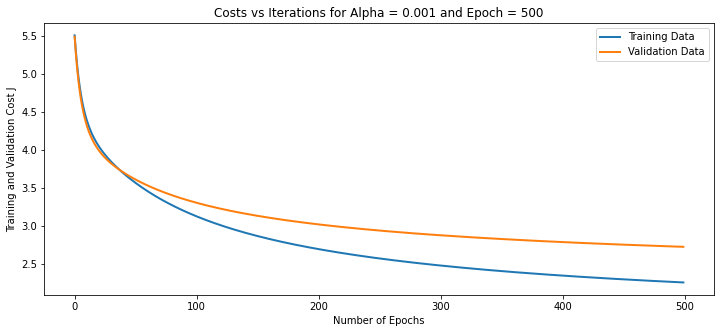

In [20]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_e1[0])), temp_tcosts_e1[0], lw=2)
plt.plot(np.arange(len(temp_vcosts_e1[0])), temp_vcosts_e1[0], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas[0], epochs[0]))
plt.legend(['Training Data', 'Validation Data'])

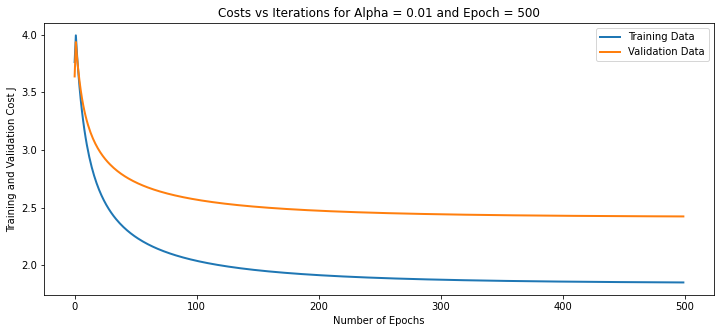

In [21]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_e1[1])), temp_tcosts_e1[1], lw=2)
plt.plot(np.arange(len(temp_vcosts_e1[1])), temp_vcosts_e1[1], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas[1], epochs[0]))
plt.legend(['Training Data', 'Validation Data'])

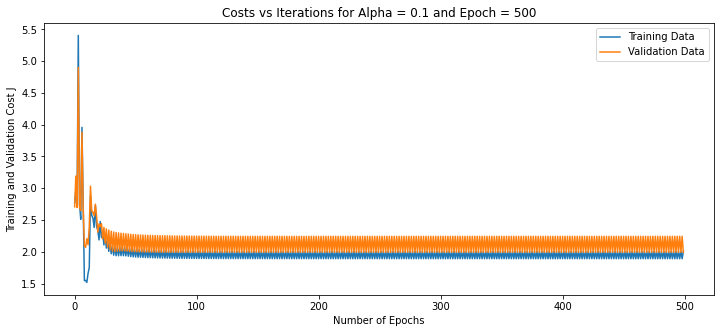

In [24]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_e1[2])), temp_tcosts_e1[2])
plt.plot(np.arange(len(temp_vcosts_e1[2])), temp_vcosts_e1[2])
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas[2], epochs[0]))
plt.legend(['Training Data', 'Validation Data'])

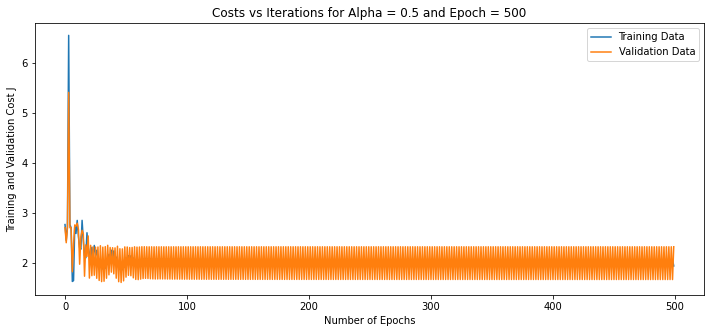

In [26]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_e1[3])), temp_tcosts_e1[3])
plt.plot(np.arange(len(temp_vcosts_e1[3])), temp_vcosts_e1[3])
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas[3], epochs[0]))
plt.legend(['Training Data', 'Validation Data'])

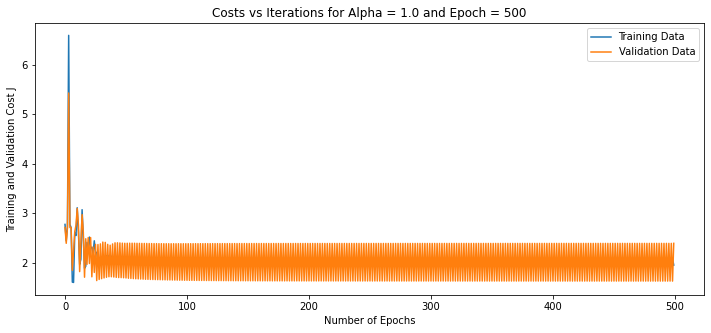

In [30]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_e1[4])), temp_tcosts_e1[4])
plt.plot(np.arange(len(temp_vcosts_e1[4])), temp_vcosts_e1[4])
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas[4], epochs[0]))
plt.legend(['Training Data', 'Validation Data'])

*** Epoch # 2 ***

In [31]:
temp_vcosts_e1 = []
temp_tcosts_e1 = []
for i in range(len(alphas)):
  new_weights, J, J2 = gradient_descent(X_train, one_h_train, X_valid, one_h_valid, weights, alphas[i], epochs[1])
  temp_tcosts_e1.append(J)
  temp_vcosts_e1.append(J2)

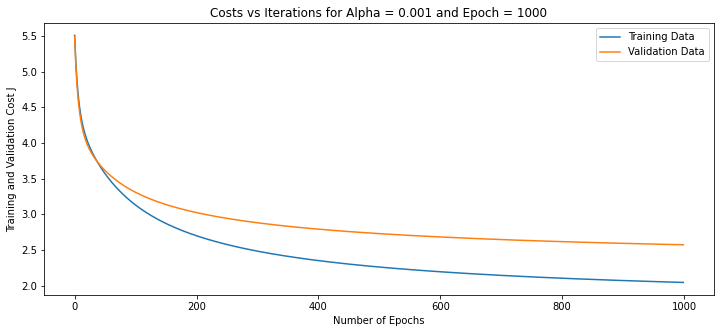

In [32]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_e1[0])), temp_tcosts_e1[0])
plt.plot(np.arange(len(temp_vcosts_e1[0])), temp_vcosts_e1[0])
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas[0], epochs[1]))
plt.legend(['Training Data', 'Validation Data'])

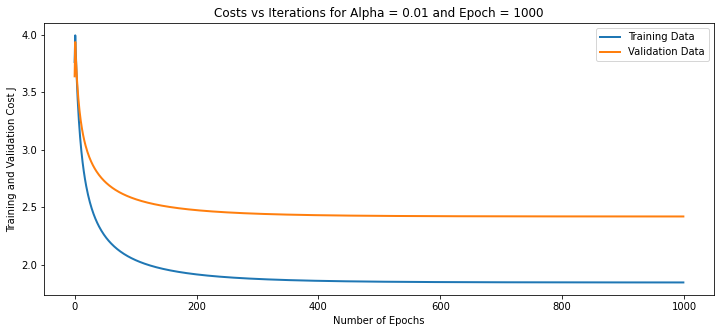

In [33]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_e1[1])), temp_tcosts_e1[1], lw=2)
plt.plot(np.arange(len(temp_vcosts_e1[1])), temp_vcosts_e1[1], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas[1], epochs[1]))
plt.legend(['Training Data', 'Validation Data'])

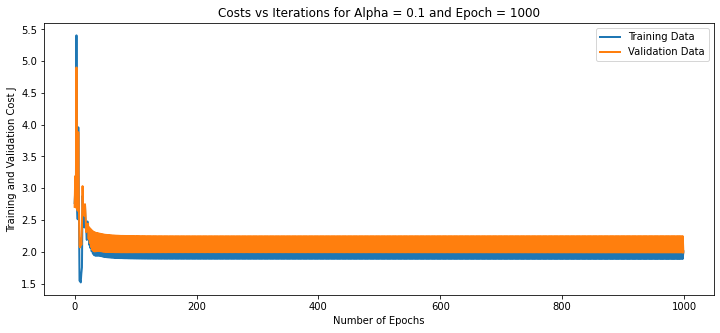

In [34]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_e1[2])), temp_tcosts_e1[2], lw=2)
plt.plot(np.arange(len(temp_vcosts_e1[2])), temp_vcosts_e1[2], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas[2], epochs[1]))
plt.legend(['Training Data', 'Validation Data'])

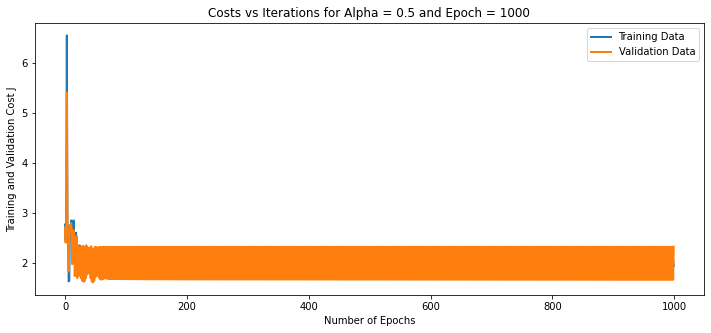

In [35]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_e1[3])), temp_tcosts_e1[3], lw=2)
plt.plot(np.arange(len(temp_vcosts_e1[3])), temp_vcosts_e1[3], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas[3], epochs[1]))
plt.legend(['Training Data', 'Validation Data'])

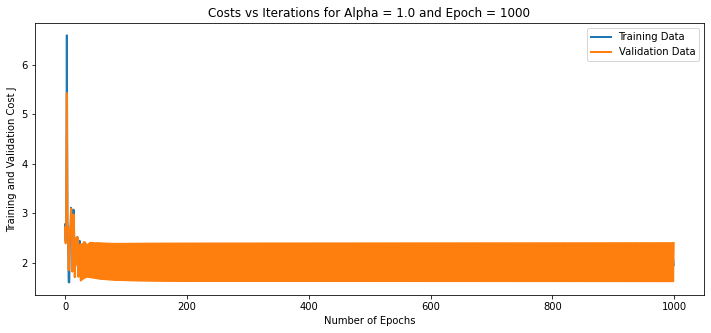

In [36]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_e1[4])), temp_tcosts_e1[4], lw=2)
plt.plot(np.arange(len(temp_vcosts_e1[4])), temp_vcosts_e1[4], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas[4], epochs[1]))
plt.legend(['Training Data', 'Validation Data'])

*** Epoch #3 *** 

In [37]:
temp_vcosts_e1 = []
temp_tcosts_e1 = []
for i in range(len(alphas)):
  new_weights, J, J2 = gradient_descent(X_train, one_h_train, X_valid, one_h_valid, weights, alphas[i], epochs[2])
  temp_tcosts_e1.append(J)
  temp_vcosts_e1.append(J2)

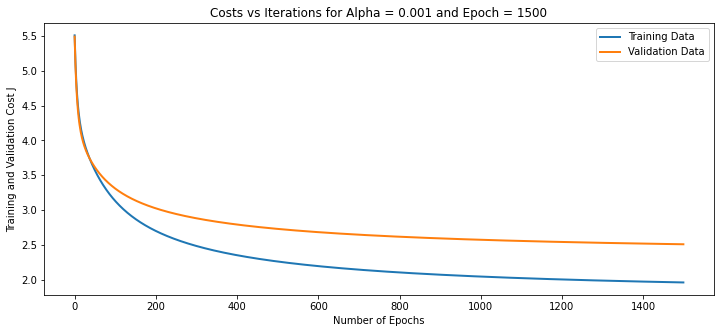

In [38]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_e1[0])), temp_tcosts_e1[0], lw=2)
plt.plot(np.arange(len(temp_vcosts_e1[0])), temp_vcosts_e1[0], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas[0], epochs[2]))
plt.legend(['Training Data', 'Validation Data'])

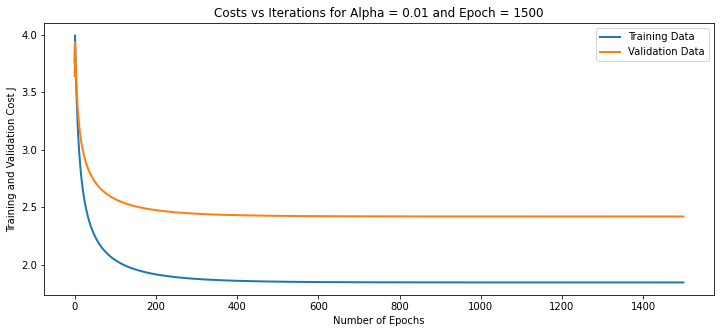

In [39]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_e1[1])), temp_tcosts_e1[1], lw=2)
plt.plot(np.arange(len(temp_vcosts_e1[1])), temp_vcosts_e1[1], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas[1], epochs[2]))
plt.legend(['Training Data', 'Validation Data'])

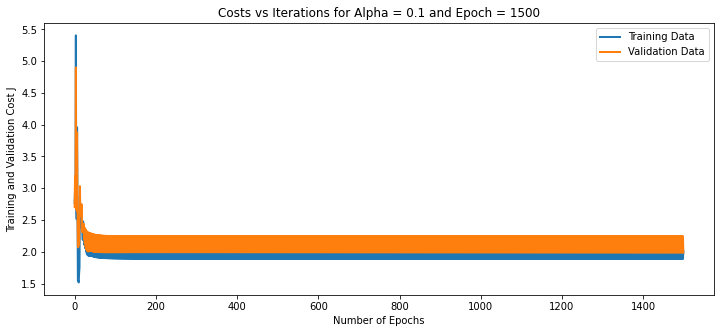

In [40]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_e1[2])), temp_tcosts_e1[2], lw=2)
plt.plot(np.arange(len(temp_vcosts_e1[2])), temp_vcosts_e1[2], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas[2], epochs[2]))
plt.legend(['Training Data', 'Validation Data'])

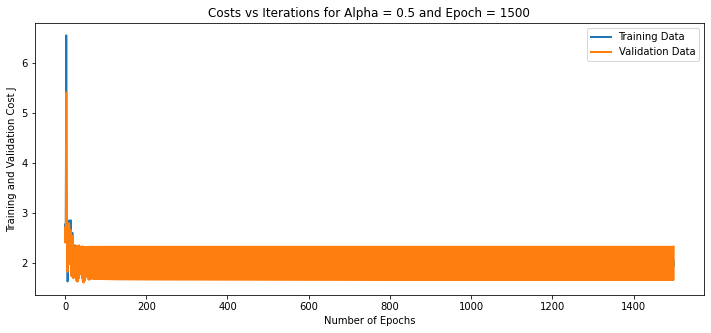

In [41]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_e1[3])), temp_tcosts_e1[3], lw=2)
plt.plot(np.arange(len(temp_vcosts_e1[3])), temp_vcosts_e1[3], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas[3], epochs[2]))
plt.legend(['Training Data', 'Validation Data'])

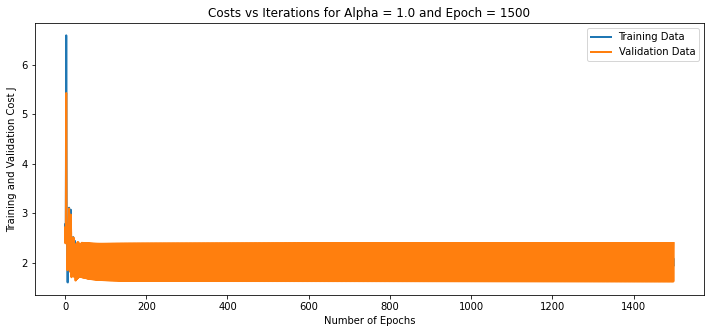

In [42]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_e1[4])), temp_tcosts_e1[4], lw=2)
plt.plot(np.arange(len(temp_vcosts_e1[4])), temp_vcosts_e1[4], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas[4], epochs[2]))
plt.legend(['Training Data', 'Validation Data'])

*** Calculating new Weights using Best Alpha and Epoch ***

In [68]:
new_weights, J, J2 = gradient_descent(X_train, one_h_train, X_valid, one_h_valid, weights, 0.1, 500)

In [69]:
new_weights.shape

(2, 14)

*** Calculating Accuracy ***

In [71]:
y_pred = index_preds(X_test, new_weights)

In [72]:
y_pred.shape

(170,)

In [73]:
acc_score, macro_precision, macro_recall, macro_f1, confusion, classifcation = final_accuracies(y_test, y_pred)

print("Accuracy Score is: {}%".format(acc_score))
print("Macroaveraged Recall is: {}%".format(macro_recall))
print("Macroaveraged Precision is: {}%".format(macro_precision))
print("Macroaveraged F1-score is: {}%".format(macro_f1))

Accuracy Score is: 84.0%
Macroaveraged Recall is: 85.0%
Macroaveraged Precision is: 78.0%
Macroaveraged F1-score is: 81.0%


In [74]:
print("\nConfusion Matrix :\n")
print(confusion)


Confusion Matrix :

[[ 35   5]
 [ 22 108]]


In [75]:
print("\nClassification Report:\n")
print(classifcation)


Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.88      0.72        40
           1       0.96      0.83      0.89       130

    accuracy                           0.84       170
   macro avg       0.78      0.85      0.81       170
weighted avg       0.88      0.84      0.85       170



### Speaker Recognition

In [100]:
def extract_label(file):
  r = file.split('SPK')[-1]
  return r[:3]

def get_features(directory):
  features_list = []
  labels_list = []
  for file in glob.iglob(directory):
    extracted_label = extract_label(file)
    labels_list.append(extracted_label)
    sr, audio = read(file)
    features = get_MFCC(audio, sr)
    features_list.append(features)
  return get_array(features_list, labels_list)

def get_array(features, labels):
  m = len(features)
  X = np.concatenate([np.ones((m, 1)), features], axis=1)
  X, Y = np.array(X), np.array(list(map(int, labels)))
  return X, Y.reshape(Y.shape[0], 1)

def one_hot_converter2(labels,y):
    one_hot = []
    for i in range(len(y)):
        vec = np.zeros((len(labels,)))
        vec[y[i][0]] = 1
        one_hot.append(vec)
    return np.array(one_hot)

In [101]:
starttime = time.time() 
X_train_speaker, y_train_speaker = get_features("Dataset/Speaker_Recognition/Train/**/*.wav")
print ("Training Reading Time is = ", str(time.time() - starttime) + " seconds")

starttime = time.time() 
X_valid_speaker, y_valid_speaker = get_features("Dataset/Speaker_Recognition/Valid/**/*.wav")
print ("Validation Reading Time is = ", str(time.time() - starttime) + " seconds")

starttime = time.time() 
X_test_speaker, y_test_speaker = get_features("Dataset/Speaker_Recognition/Test/**/*.wav")
print ("TestingReading Time is = ", str(time.time() - starttime) + " seconds")

Training Reading Time is =  573.2192802429199 seconds
Validation Reading Time is =  223.45127296447754 seconds
TestingReading Time is =  207.42233419418335 seconds


In [102]:
print("Training Data X", X_train_speaker.shape)
print("Validation Data X", X_valid_speaker.shape)
print("Testing Data X", X_test_speaker.shape)
print()
print("Training Data Y", y_train_speaker.shape)
print("Validation Data Y", y_valid_speaker.shape)
print("Testing Data Y", y_test_speaker.shape)

Training Data X (852, 14)
Validation Data X (284, 14)
Testing Data X (284, 14)

Training Data Y (852, 1)
Validation Data Y (284, 1)
Testing Data Y (284, 1)


In [103]:
unique_labels_speaker = np.unique(y_train_speaker)
unique_labels_speaker.shape

(142,)

In [104]:
one_h_train_speaker = one_hot_converter2(np.unique(y_train_speaker).astype(int)-1, y_train_speaker.astype(int)-1)
one_h_valid_speaker = one_hot_converter2(np.unique(y_valid_speaker).astype(int)-1, y_valid_speaker.astype(int)-1)
one_h_test_speaker  = one_hot_converter2(np.unique(y_test_speaker).astype(int)-1, y_test_speaker.astype(int)-1)

In [105]:
print("Hot Encoding Training Y", one_h_train_speaker.shape)
print("Hot Encoding Validation Y", one_h_valid_speaker.shape)
print("Hot Encoding Testing Y", one_h_test_speaker.shape)

Hot Encoding Training Y (852, 142)
Hot Encoding Validation Y (284, 142)
Hot Encoding Testing Y (284, 142)


In [106]:
weights_speaker = generate_weight_matrix(one_h_train_speaker.shape[1], X_train_speaker.shape[1])
weights_speaker.shape

(142, 14)

In [107]:
## Epoch and Alphas List:
alphas_sp = [0.001, 0.01, 0.1, 0.5, 1.0]
epochs_sp = [2000, 2500, 3000]

*** Epoch # 1 ***

In [108]:
temp_vcosts_s1 = []
temp_tcosts_s1 = []
for i in range(len(alphas)):
  new_weights, J, J2 = gradient_descent(X_train_speaker, one_h_train_speaker, X_valid_speaker, one_h_valid_speaker, weights_speaker, alphas_sp[i], epochs_sp[0])
  temp_tcosts_s1.append(J)
  temp_vcosts_s1.append(J2)

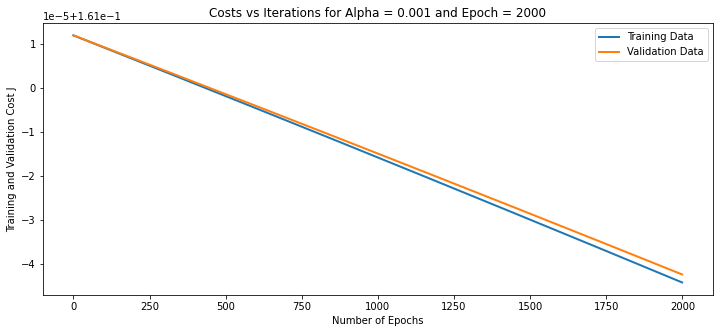

In [109]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_s1[0])), temp_tcosts_s1[0], lw=2)
plt.plot(np.arange(len(temp_vcosts_s1[0])), temp_vcosts_s1[0], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas_sp[0], epochs_sp[0]))
plt.legend(['Training Data', 'Validation Data'])

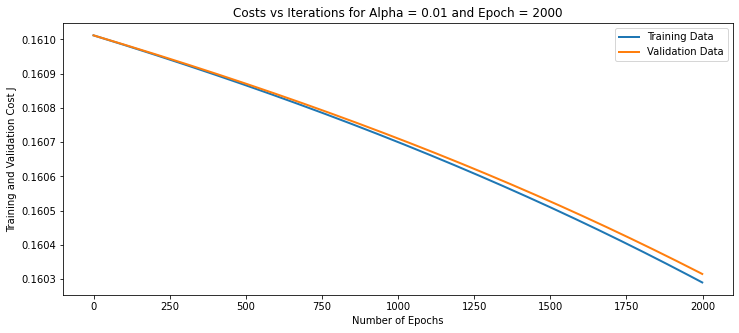

In [110]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_s1[1])), temp_tcosts_s1[1], lw=2)
plt.plot(np.arange(len(temp_vcosts_s1[1])), temp_vcosts_s1[1], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas_sp[1], epochs_sp[0]))
plt.legend(['Training Data', 'Validation Data'])

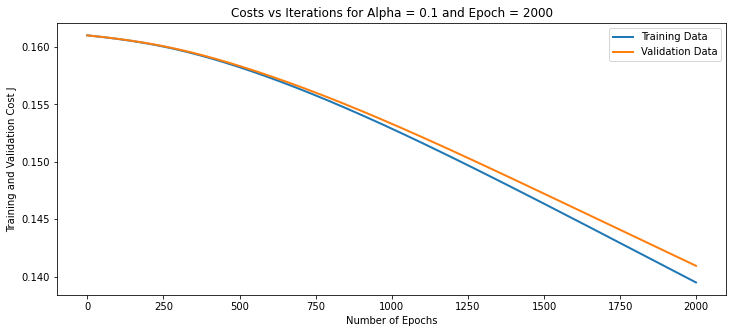

In [111]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_s1[2])), temp_tcosts_s1[2], lw=2)
plt.plot(np.arange(len(temp_vcosts_s1[2])), temp_vcosts_s1[2], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas_sp[2], epochs_sp[0]))
plt.legend(['Training Data', 'Validation Data'])

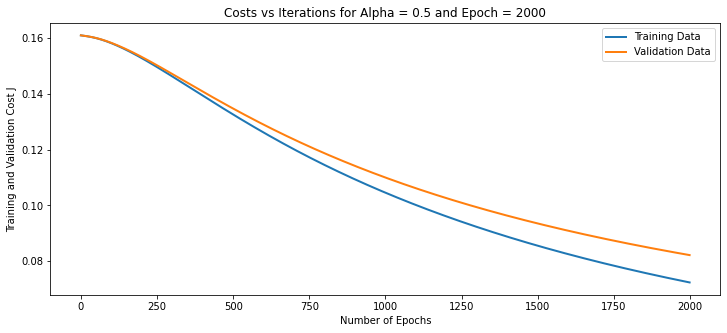

In [112]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_s1[3])), temp_tcosts_s1[3], lw=2)
plt.plot(np.arange(len(temp_vcosts_s1[3])), temp_vcosts_s1[3], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas_sp[3], epochs_sp[0]))
plt.legend(['Training Data', 'Validation Data'])

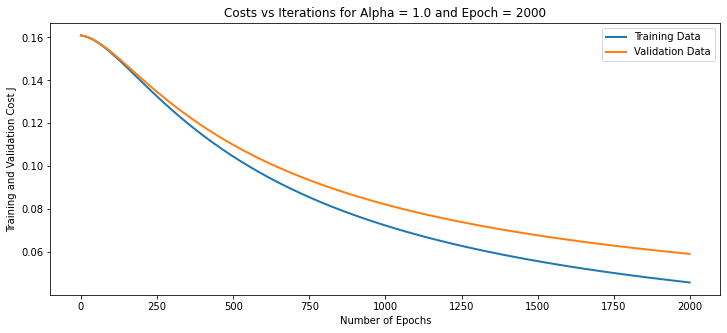

In [113]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_s1[4])), temp_tcosts_s1[4], lw=2)
plt.plot(np.arange(len(temp_vcosts_s1[4])), temp_vcosts_s1[4], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas_sp[4], epochs_sp[0]))
plt.legend(['Training Data', 'Validation Data'])

*** Epoch # 2 ***

In [114]:
temp_vcosts_s1 = []
temp_tcosts_s1 = []
for i in range(len(alphas)):
  new_weights, J, J2 = gradient_descent(X_train_speaker, one_h_train_speaker, X_valid_speaker, one_h_valid_speaker, weights_speaker, alphas_sp[i], epochs_sp[1])
  temp_tcosts_s1.append(J)
  temp_vcosts_s1.append(J2)

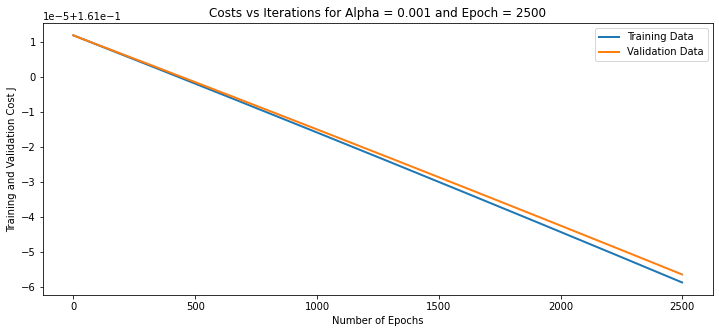

In [115]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_s1[0])), temp_tcosts_s1[0], lw=2)
plt.plot(np.arange(len(temp_vcosts_s1[0])), temp_vcosts_s1[0], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas_sp[0], epochs_sp[1]))
plt.legend(['Training Data', 'Validation Data'])

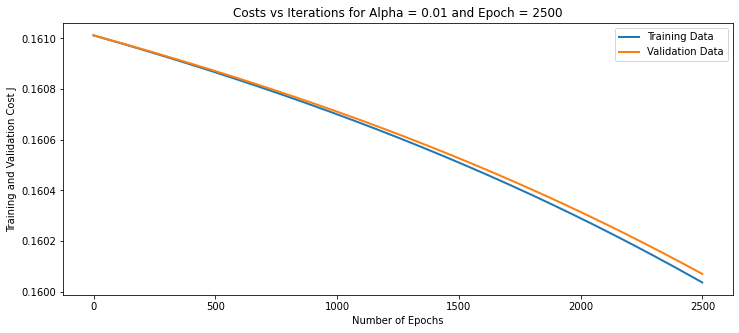

In [116]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_s1[1])), temp_tcosts_s1[1], lw=2)
plt.plot(np.arange(len(temp_vcosts_s1[1])), temp_vcosts_s1[1], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas_sp[1], epochs_sp[1]))
plt.legend(['Training Data', 'Validation Data'])

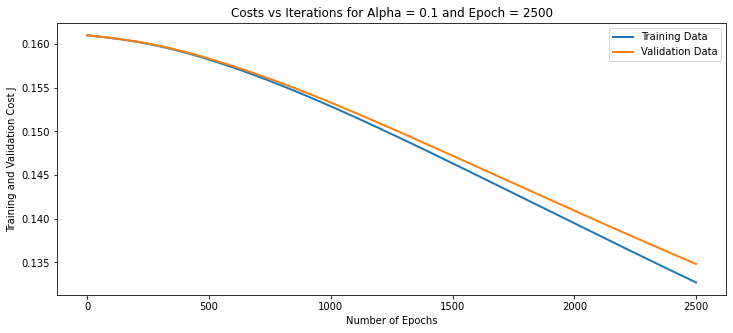

In [117]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_s1[2])), temp_tcosts_s1[2], lw=2)
plt.plot(np.arange(len(temp_vcosts_s1[2])), temp_vcosts_s1[2], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas_sp[2], epochs_sp[1]))
plt.legend(['Training Data', 'Validation Data'])

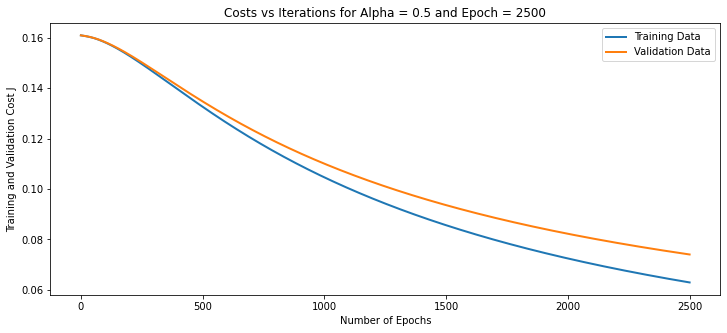

In [118]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_s1[3])), temp_tcosts_s1[3], lw=2)
plt.plot(np.arange(len(temp_vcosts_s1[3])), temp_vcosts_s1[3], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas_sp[3], epochs_sp[1]))
plt.legend(['Training Data', 'Validation Data'])

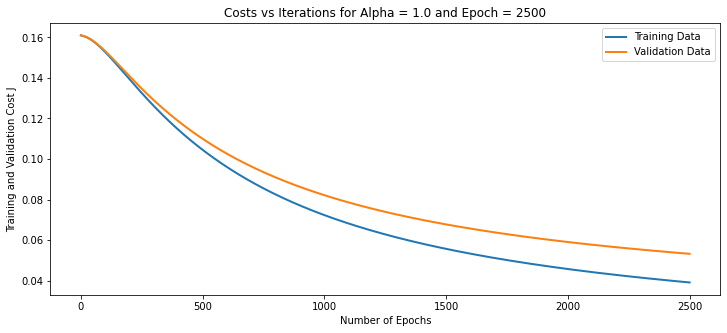

In [119]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_s1[4])), temp_tcosts_s1[4], lw=2)
plt.plot(np.arange(len(temp_vcosts_s1[4])), temp_vcosts_s1[4], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas_sp[4], epochs_sp[1]))
plt.legend(['Training Data', 'Validation Data'])

*** Epoch #3 *** 

In [120]:
temp_vcosts_s1 = []
temp_tcosts_s1 = []
for i in range(len(alphas)):
  new_weights, J, J2 = gradient_descent(X_train_speaker, one_h_train_speaker, X_valid_speaker, one_h_valid_speaker, weights_speaker, alphas_sp[i], epochs_sp[2])
  temp_tcosts_s1.append(J)
  temp_vcosts_s1.append(J2)

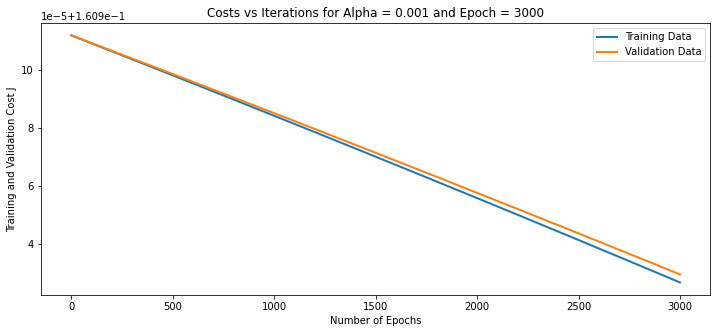

In [121]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_s1[0])), temp_tcosts_s1[0], lw=2)
plt.plot(np.arange(len(temp_vcosts_s1[0])), temp_vcosts_s1[0], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas_sp[0], epochs_sp[2]))
plt.legend(['Training Data', 'Validation Data'])

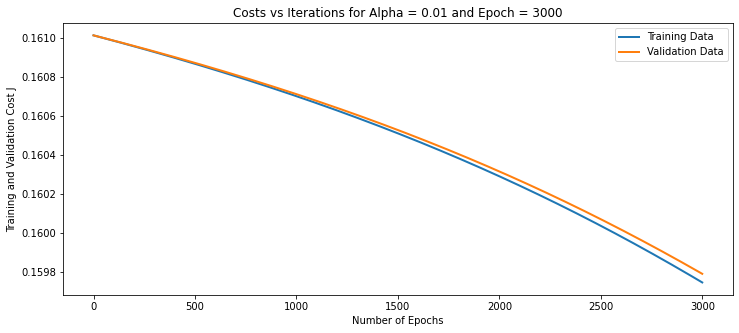

In [122]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_s1[1])), temp_tcosts_s1[1], lw=2)
plt.plot(np.arange(len(temp_vcosts_s1[1])), temp_vcosts_s1[1], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas_sp[1], epochs_sp[2]))
plt.legend(['Training Data', 'Validation Data'])

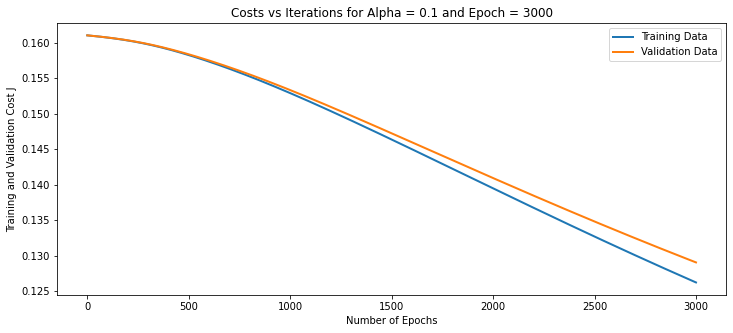

In [123]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_s1[2])), temp_tcosts_s1[2], lw=2)
plt.plot(np.arange(len(temp_vcosts_s1[2])), temp_vcosts_s1[2], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas_sp[2], epochs_sp[2]))
plt.legend(['Training Data', 'Validation Data'])

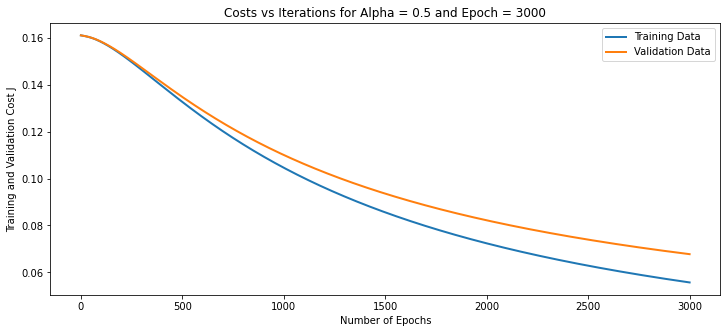

In [124]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_s1[3])), temp_tcosts_s1[3], lw=2)
plt.plot(np.arange(len(temp_vcosts_s1[3])), temp_vcosts_s1[3], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas_sp[3], epochs_sp[2]))
plt.legend(['Training Data', 'Validation Data'])

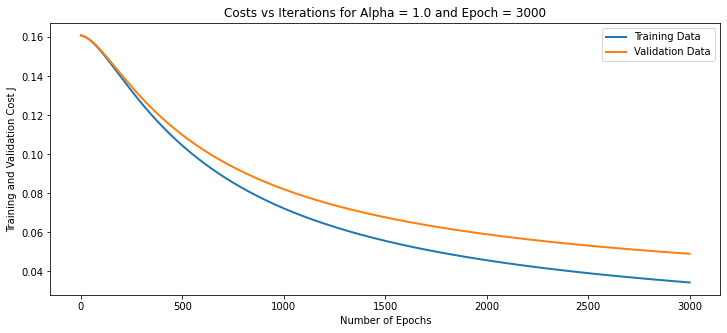

In [125]:
# Plotting the Training Cost vs Epoch Graph
fig = plt.figure(figsize=(12,5))
plt.plot(np.arange(len(temp_tcosts_s1[4])), temp_tcosts_s1[4], lw=2)
plt.plot(np.arange(len(temp_vcosts_s1[4])), temp_vcosts_s1[4], lw=2)
plt.xlabel('Number of Epochs')
plt.ylabel('Training and Validation Cost J')
plt.title('Costs vs Iterations for Alpha = {} and Epoch = {}'.format(alphas_sp[4], epochs_sp[2]))
plt.legend(['Training Data', 'Validation Data'])

*** Calculating new Weights using Best Alpha and Epoch ***

In [126]:
new_weights, J_speaker, valid_speaker = gradient_descent(X_train_speaker, one_h_train_speaker, X_valid_speaker, one_h_valid_speaker, weights_speaker, 1.0, 3000)

In [127]:
new_weights.shape

(142, 14)

In [128]:
new_weights

array([[-0.00095545, -0.04275539,  0.24194045, ...,  0.00971667,
        -0.00317614,  0.02026061],
       [-0.00632708, -0.10026473,  0.24710599, ..., -0.08805341,
         0.12572421,  0.00400312],
       [-0.0037286 , -0.02449233, -0.26224152, ...,  0.10613355,
        -0.04985601, -0.06504036],
       ...,
       [ 0.01345796,  0.19778171, -0.29847944, ..., -0.00692286,
         0.20633842,  0.05718342],
       [-0.00710645, -0.06551873, -0.27772183, ..., -0.05931068,
        -0.10413296,  0.06197631],
       [ 0.00605126,  0.02351836, -0.27753111, ..., -0.09988667,
         0.09428093,  0.07039363]])

*** Calculating Accuracy ***

In [129]:
y_pred_update = index_preds(X_test_speaker, new_weights)

In [130]:
y_pred_update.shape

(284,)

In [131]:
acc_score_speak, macro_precision_speak, macro_recall_speak, macro_f1_speak, confusion_speak, classifcation_speak = final_accuracies(y_test_speaker.astype(int)-1, y_pred_update)

print("Accuracy Score is: {}%".format(acc_score_speak))
print("Macroaveraged Recall is: {}%".format(macro_recall_speak))
print("Macroaveraged Precision is: {}%".format(macro_precision_speak))
print("Macroaveraged F1-score is: {}%".format(macro_f1_speak))

Accuracy Score is: 96.0%
Macroaveraged Recall is: 96.0%
Macroaveraged Precision is: 97.0%
Macroaveraged F1-score is: 96.0%


In [132]:
print("\nConfusion Matrix :\n")
print(confusion_speak)


Confusion Matrix :

[[2 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]


In [133]:
print("\nClassification Report:\n")
print(classifcation_speak)


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       0.67      1.00      0.80         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
  